In [796]:
import os
import pickle

import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision;

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from scripts import *

In [797]:
# input
model_checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
save_path = "experiments/ganspace/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"

#model_checkpoint = "experiments/dcgan_resnet/lightning_logs/version_0/checkpoints/epoch=524.ckpt"
#save_path = "experiments/ganspace/dcgan_resnet_version_0_epoch=524"

# optional
n_samples = 5000
n_time = 5
layer = "linear"

In [798]:
model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()
1

1

In [799]:
@th.no_grad()
def get_inner_act(model, n_samples=10000, layer="linear"):
    z = th.normal(0, 1, size=(n_samples, model.generator.latent_dim), device=model.device)
    l = model.generator.l1(z)
    if layer == "conv-1":
        l = l.view(l.shape[0],  model.generator.init_channels,
                            model.generator.init_height,  model.generator.init_width)
        l = model.generator.conv_blocks[0](l)
        l = model.generator.conv_blocks[1](l)
        l = model.generator.conv_blocks[2](l)
        l = l.view(l.shape[0], -1)

    X = np.squeeze(l.detach().cpu().numpy())
    y = np.squeeze(z.detach().cpu().numpy())    
    return X, y

In [800]:
pca_path = os.path.join(save_path, layer, "pca.pkl")


if not os.path.exists(pca_path):
    pca = IncrementalPCA(n_components=4096 if layer == "linear" else 16384)
    os.makedirs(os.path.join(save_path, layer), exist_ok=True)

    for i in range(n_time):
        print("Iteration - ", i+1)
        X, y = get_inner_act(model, n_samples, layer=layer)

        # save the data
        np.save(os.path.join(save_path, layer, f"y{i+1}.npy"), y)
        np.save(os.path.join(save_path, layer, f"X{i+1}.npy"), X)

        pca.partial_fit(X)

    # save the pca
    f = open(pca_path, "wb")
    pickle.dump(pca, f)
    f.close()
else:
    f = open(pca_path, 'rb')
    pca = pickle.load(f)
    f.close()

In [801]:
# load dataset
X = np.concatenate([np.load(os.path.join(save_path, layer, f"X{i+1}.npy")) for i in range(n_time)], axis=0)
y = np.concatenate([np.load(os.path.join(save_path, layer, f"y{i+1}.npy")) for i in range(n_time)], axis=0)

# information gain
information_gain = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(information_gain >= 0.9)[0][0]

# 
comp = pca.components_[:idx]
mean = pca.mean_

# reconstruction
X_pca = (X - mean).dot(comp.T) 

# resonctruction error
X_rec = X_pca.dot(comp) + mean
np.linalg.norm(X_rec - X) / len(X)

0.06401260185786002

In [802]:
X_pca.shape

(25000, 28)

In [803]:
reg_path = os.path.join(save_path, layer, "reg.pkl")

if not os.path.exists(reg_path):
    reg = LinearRegression(normalize=True).fit(X_pca, y)
    f = open(reg_path, "wb")
    pickle.dump(reg, f)
    f.close()
else:
    f = open(reg_path, 'rb')
    reg = pickle.load(f)
    f.close()   
    
np.linalg.norm(X_pca.dot(reg.coef_.T) - y) / len(X)

0.05362080250835601

Text(0.5, 0, 'Principal Components')

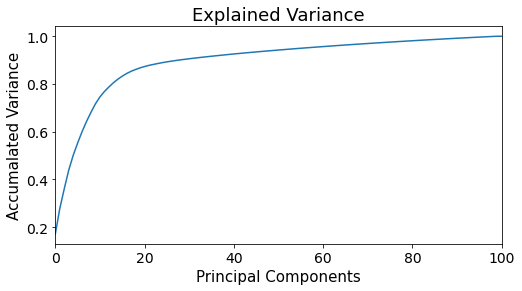

In [804]:
information_gain = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(information_gain)
# plt.plot([idx, idx], [information_gain[idx], information_gain[idx]], marker=".")
plt.xlim([0, 100])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Explained Variance", fontsize=18)
plt.ylabel("Accumalated Variance", fontsize=15)
plt.xlabel("Principal Components", fontsize=15)

Text(0.5, 0, 'Principal Components')

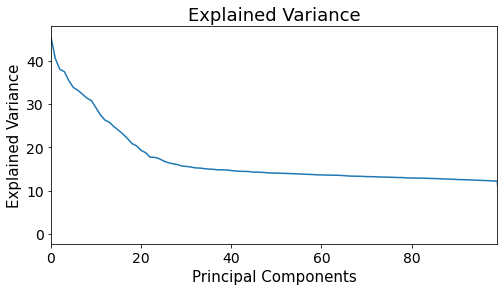

In [805]:

plt.figure(figsize=(8, 4))
plt.plot(np.sqrt(pca.singular_values_))
plt.xlim([0, 99])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Explained Variance", fontsize=18)
plt.ylabel("Explained Variance", fontsize=15)
plt.xlabel("Principal Components", fontsize=15)


Text(0.5, 0, 'Principal Components')

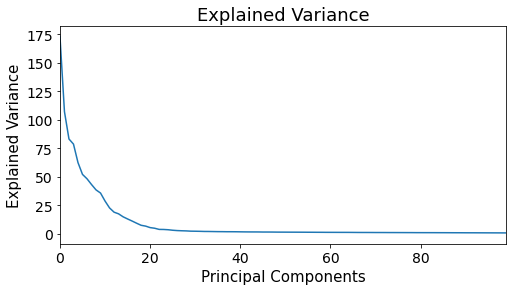

In [806]:
plt.figure(figsize=(8, 4))
plt.plot(pca.explained_variance_)
plt.xlim([0, 99])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Explained Variance", fontsize=18)
plt.ylabel("Explained Variance", fontsize=15)
plt.xlabel("Principal Components", fontsize=15)

In [1215]:
@th.no_grad()
def explore_principle_direction(idx, U, model, zs, ratios=None):
    
    size = U.shape[1]
    n_samples = zs.shape[0]
    if ratios is None:
        ratios = np.linspace(-0.5, 0.5, 11)
   
    x = th.zeros((size,), device=model.device, dtype=zs.dtype)
    
    imgs = []
    for z in zs:
        for ratio in ratios:
            x[idx] = ratio
            z_ = z + th.matmul(U, x)
            
            img = th.squeeze(model(th.unsqueeze(z_, dim=0)))
            imgs.append(img)
    
    # make grid
    grid = torchvision.utils.make_grid(imgs, nrow=len(ratios), normalize=True)
    return grid


@th.no_grad()
def explore_principle_direction_pca(idx, E, mu, model, zs, ratios):
    
    n_samples = zs.shape[0]

    
    imgs = []
    for z in zs:
        for ratio in ratios:
            l = model.l1(th.unsqueeze(z, dim=0))
            l = th.squeeze(l)
            l_pca = (l - mu).matmul(E.T)
            l_pca[idx] = ratio
            l_rec = l_pca.matmul(E) + mu
            l_rec = l_rec.view(1,  model.init_channels,
                    model.init_height,  model.init_width)
            
            img = th.squeeze(model.conv_blocks(l_rec))
            imgs.append(img)
        #print(2*l_pca[idx])
    # make grid
    grid = torchvision.utils.make_grid(imgs, nrow=len(ratios), normalize=True)
    return grid


def explore_pca(idx, E, mu, means, stds, model, ratios):
    imgs = []

    for i in range(20):
        point = th.tensor([np.random.normal(mean, scale) for mean, scale in zip(means, stds)], device=model.device)
        
        point[0] = max(point[0], 11.8467328) if point[0] > 0 else min(point[0], -11.8467328)
            
        for ratio in ratios:
            point[idx] = ratio
            
            l_rec = point.matmul(E) + mu
            l_rec = l_rec.view(1,  model.generator.init_channels,
                    model.generator.init_height,  model.generator.init_width)
            img = th.squeeze(model.generator.conv_blocks(l_rec))
            imgs.append(img)
            
    grid = torchvision.utils.make_grid(imgs, nrow=len(ratios), normalize=True)
    return grid

In [1035]:
stds, means= [], []
for x in X_pca[:, :idx].T:
    means.append(x.mean())
    stds.append(x.std())

In [1036]:
zs = th.normal(0, 1, size=(15, model.generator.latent_dim), device=model.device) 
#zs = th.zeros((15, model.generator.latent_dim), device=model.device) 
E = th.tensor(comp, device=model.device, dtype=zs.dtype)
mu = th.tensor(mean, device=model.device, dtype=zs.dtype)
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

# model

model_checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
save_path = "experiments/ganspace/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim
i = 0, +/- 3*std*0.3, orientation of the car - look right + look left
i = 1, +/- 3*std, - van, + brown car
i = 2, +/- 3*std*0.5, 
i = 3, +/- 3*std*0.75, moves car up/down
i = 4, (-3*std, 0), adds top window
i = 5, (-3*std*0.75, 0) : makes car thicker and higlights its surrounding and adds strips on top
i = 6, 
i = 7, +/- 3*std, - makes car reddish and thicker, + makes car blueish and thinner
i = 8, +/- 3*std, - makes car blueish, + makes car reddish and add bright spot
i = 9, +/- 3*std, keep zero, doesn't have any results
i = 10, +/- 3*std*1.75, - bright spots on top, + bright spots on bottom
i = 11, +/- 3*std, - bright background, + dark background
i = 12, -3*std*1.5, - makes car shorter and brighter
i = 13, +/- 3*std, keep zero, doesn't have any results
i = 14, +/- 3*std*2, - bright spot and window on the top, + darker right
i = 15, +/- 3*std*1.5, - makes car longer, + makes car shorter
i = 16, +/- 3*std*3, idk something with light
i = 17, +/- 3*std*3, - bends/rotates it counter clock wise, + bends/rotates it clock wise
i = 18, +/- 3*std*2, - makes car green, + makes car redish and higlights the lamps
i = 19, +/- 3*std*3, - add car lamps on right and makes right side flat, + add car lamps on left and makes left side flat (car orientation is important)
i = 20, 

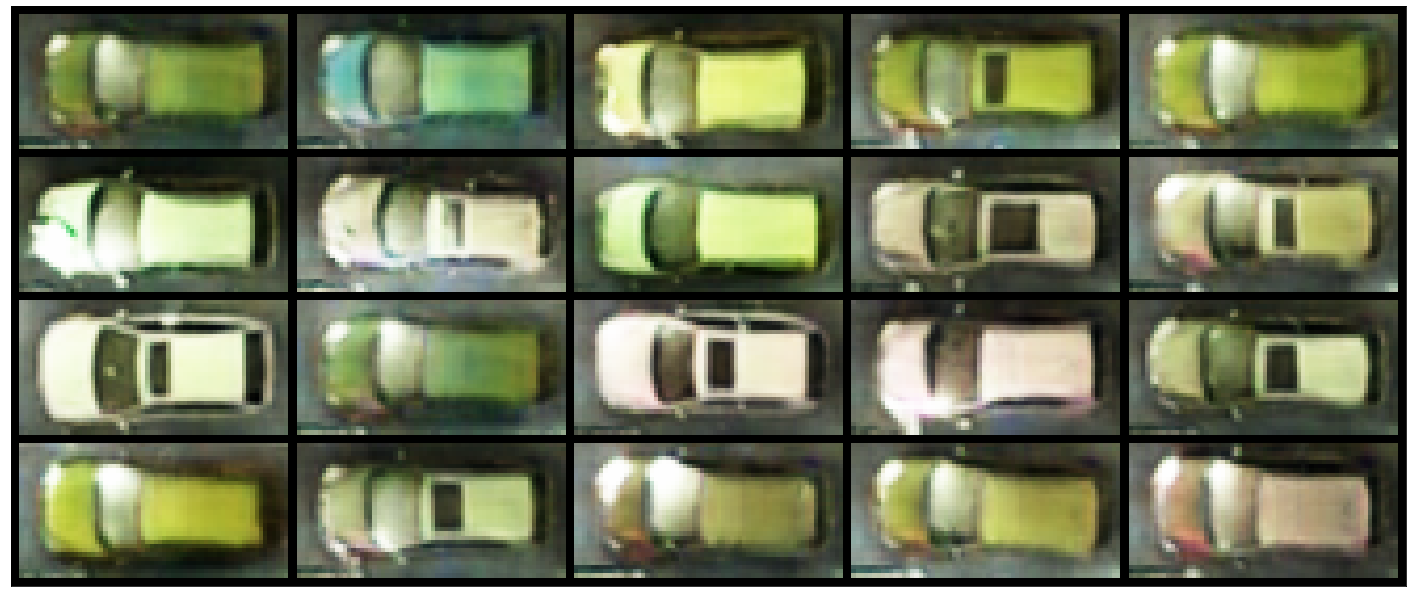

In [1317]:
idx = [9, 13]

indexes = {0:(3*0.3, 3*0.3), 
          1:(3, 3), 
          2:(1.5, 1.5), 
          3:(3*0.75, 3*0.75), 
          4:(3, 0), 
          5:(3, 3), 
          7:(3, 3),
          8:(3, 3),
          10:(3*1.75, 3*1.75),
          11:(3, 3),
          12:(3*1.5, 0),
          14:(6, 6),
         15:(3*1.5, 3*1.5),
         16:(9, 9),
         17:(9, 9),
         18 : (6, 6),
         19 : (9, 9)}

E = th.tensor(comp, device=model.device, dtype=th.float32)
mu = th.tensor(mean, device=model.device, dtype=th.float32)
scales = stds
imgs = []

with th.no_grad():    
    point = th.tensor([np.random.normal(0, scale) for scale in scales], device=model.device)
    point[0] = max(point[0], 11.8467328) if point[0] > 0 else min(point[0], -11.8467328)

    l_rec = point.matmul(E) + mu
    l_rec = l_rec.view(1,  model.generator.init_channels,
            model.generator.init_height,  model.generator.init_width)
    img =th.squeeze(model.generator.conv_blocks(l_rec))
    imgs.append(img)

    for _ in range(19):
        point2 = point.clone()
        for idx_ in indexes:
            if idx_ == 0:
                continue
            if np.random.uniform(0, 1) > 0.5:
                a, b = indexes[idx_]
                point2[idx_] = np.random.uniform(-a*scales[idx_]/2, b*scales[idx_]/2)
        for idx_ in idx:
            point2[idx] = 0

        l_rec = point2.matmul(E) + mu
        l_rec = l_rec.view(1,  model.generator.init_channels,
                model.generator.init_height,  model.generator.init_width)
        img = th.squeeze(model.generator.conv_blocks(l_rec))
        imgs.append(img)
    
grid = torchvision.utils.make_grid(imgs, nrow=5, normalize=True)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(25, 15))
plt.xticks([])
plt.yticks([])
plt.imshow(grid)

([], [])

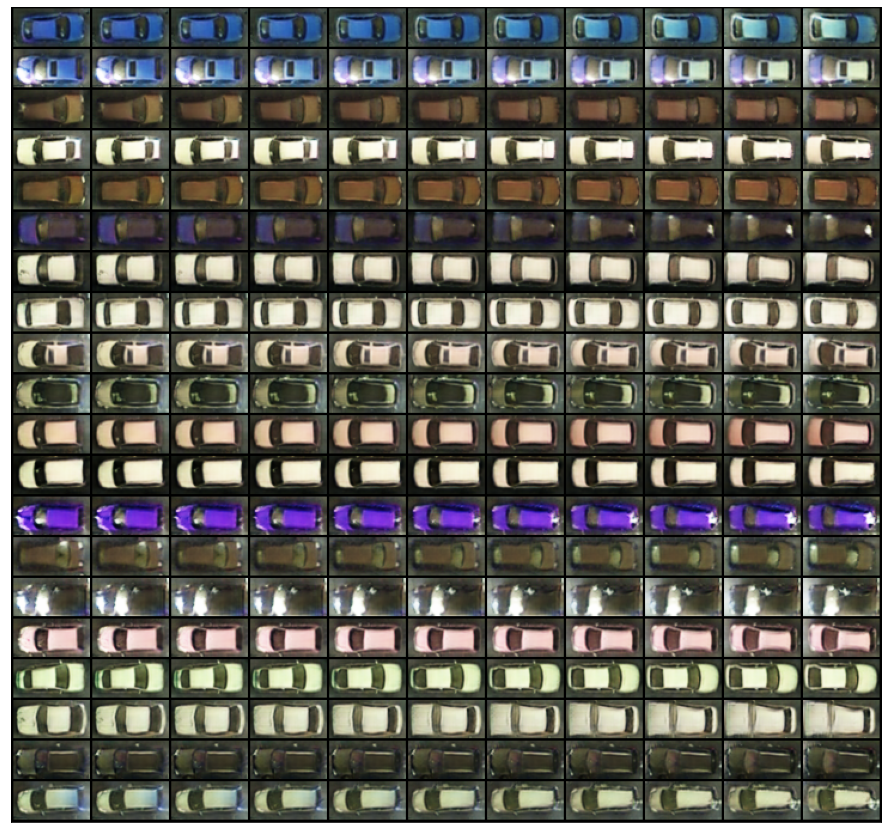

In [1225]:
i = 20
scale = 3*stds[i]
scale2 = 3
ratios = np.linspace(-scale * scale2, scale * scale2, 11)
grid = explore_pca(i, E, mu, means, stds, model, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

In [1222]:
model_checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
save_path = "experiments/ganspace/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"

# dim 1 : [-s, s] : white car
# dim 2 : [-s, s] : white van or green car
# dim 3 : [-s, s] : makes car longer but results get worse
# dim 4 : [-s/2, s/2] : move cars up and down
# dim 5 : [-s, 0] : adds top window
# dim 6 : [-s, s] : -s : makes car thicker and higlights its surrounding, s : makes car brighter color
# dim 7 : [-s, s] : -s : bright spots on right, s : bright spots on left
# dim 8 : [-s, s] : -s : makes it red/orange, s: makes it blue/purple
# dim 9 : [-s, s] : -s : makes it blue/pruple, s: makes it red/pink (looks nicer than dim 8)
# dim 10: [] : keep 0
# dim 11: [-s, s] : -s : birght spots on top, s: bright spots on bottom
# dim 12: [-s*0.75, s*0.5] : -s : makes image birghter, s : makes image darker
# dim 13: [-s*0.75: 0] : -s : makes car shorter
# dim 14 : keep 0
# dim 15 : [-s, s] : -s : bright spots on right, s : darker right
# dim 16 : [-s*0.75, s] : -s : makes car longer, s:makes car shorter
# dim 17 : [-s*0.75, s*0.75] : -s : makes bottom darker, s: makes bottom brighter
# dim 18 : [-s, s] : -s bends/rotates it counter clock wise, s : bends/rotates it clock wise
# dim 19 : [-s, s] : -s makes carish green, s: makes car redish and highlights the car lamps
# dim 20 : [-s , s] : -s : add car lamps on right, s : add car lamps on left (car orientation is important)
# dim 21 : 
# dim 22 : 
# dim 23 : 
# dim 24 : 
# dim 25 : [0, s] : s : bends the left part of the car
# dim 26 : 
# dim 27 :
# dim 28 :
# dim 29 :

([], [])

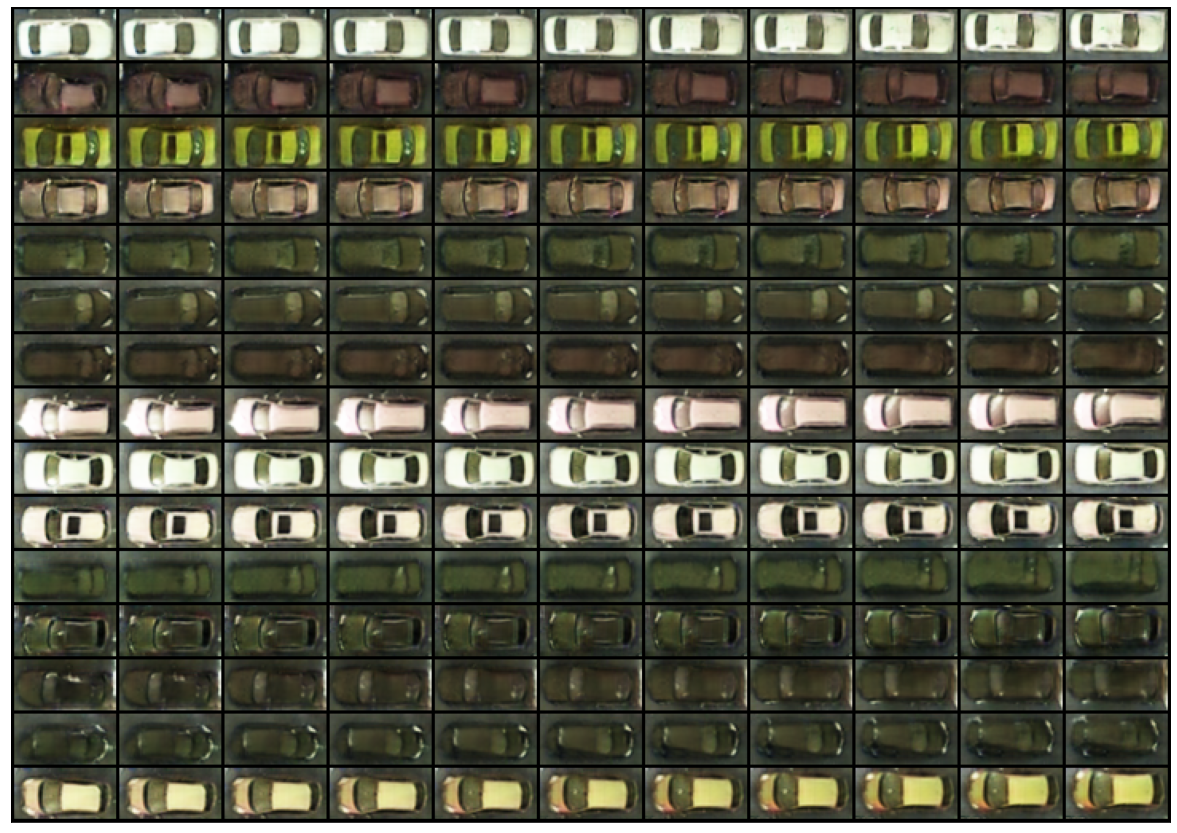

In [916]:
i = 3
scale = np.sqrt(pca.singular_values_)[i] * 0.5
ratios = np.linspace(-scale * 1, scale * 1, 11)
grid = explore_principle_direction_pca(i, E, mu, model.generator, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

([], [])

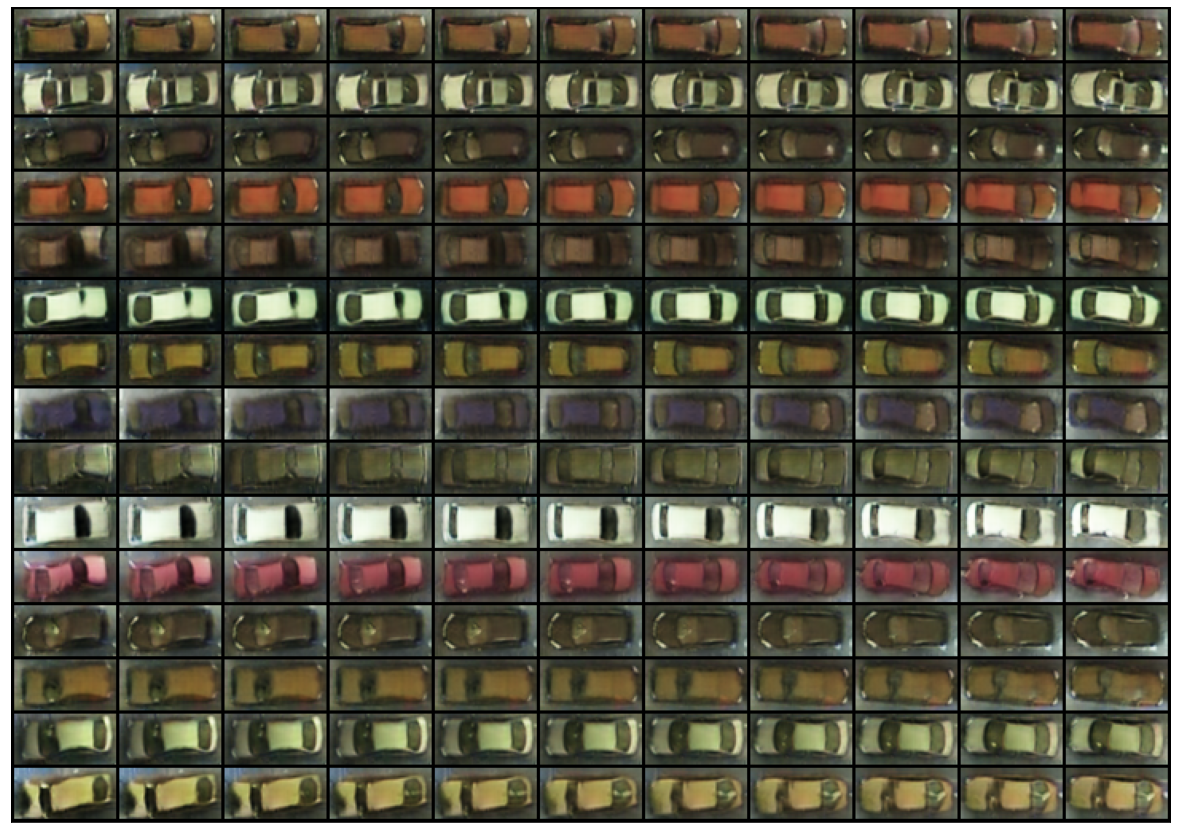

In [388]:
ratios = np.linspace(-scale * 1, scale * 1, 11)
grid = explore_principle_direction(i, U, model, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

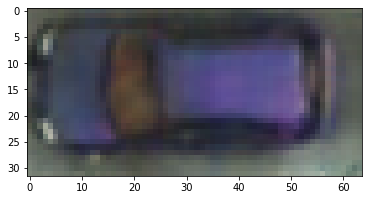

In [1203]:
E = th.tensor(comp, device=model.device, dtype=th.float32)
mu = th.tensor(mean, device=model.device, dtype=th.float32)
scales = stds

# point = th.tensor([np.random.uniform(-scale/2, scale/2) for scale in scales], device=model.device)
point = th.tensor([np.random.normal(0, scale) for scale in scales], device=model.device)

point[0] = -1*-11.8467328
#point[13] = 0


l_rec = point.matmul(E) + mu
l_rec = l_rec.view(1,  model.generator.init_channels,
        model.generator.init_height,  model.generator.init_width)
img = th.squeeze(model.generator.conv_blocks(l_rec))
img = (img.detach().cpu().numpy().transpose(1, 2, 0 ) + 1) / 2
plt.imshow(img)

In [813]:
point

tensor([  3.2935, -18.5523,  11.1468,   0.6059,  -4.6022,   3.8795,   0.6407,
          7.3248,  -9.5972,   0.6531,   0.8529,   2.7195,   2.0095,  -0.4486,
         -2.3899,   0.2193,  -1.9791,   0.9315,  -2.5164,   1.5113,  -3.0504,
         -0.3820,   0.1166,   0.8657,   1.3811,  -1.7130,  -2.6135,  -2.1683])

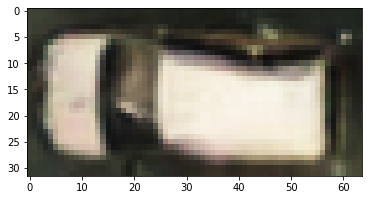

In [891]:
z = th.normal(0, 1, size=(1, model.generator.latent_dim), device=model.device) 
img = th.squeeze(model(z))
img = (img.detach().cpu().numpy().transpose(1, 2, 0 ) + 1) / 2
plt.imshow(img)

In [32]:
np.sqrt(pca.singular_values_[50]), std

(14.030773161579576, 1.2508123220882892)

In [230]:
zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
#zs = th.zeros((15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

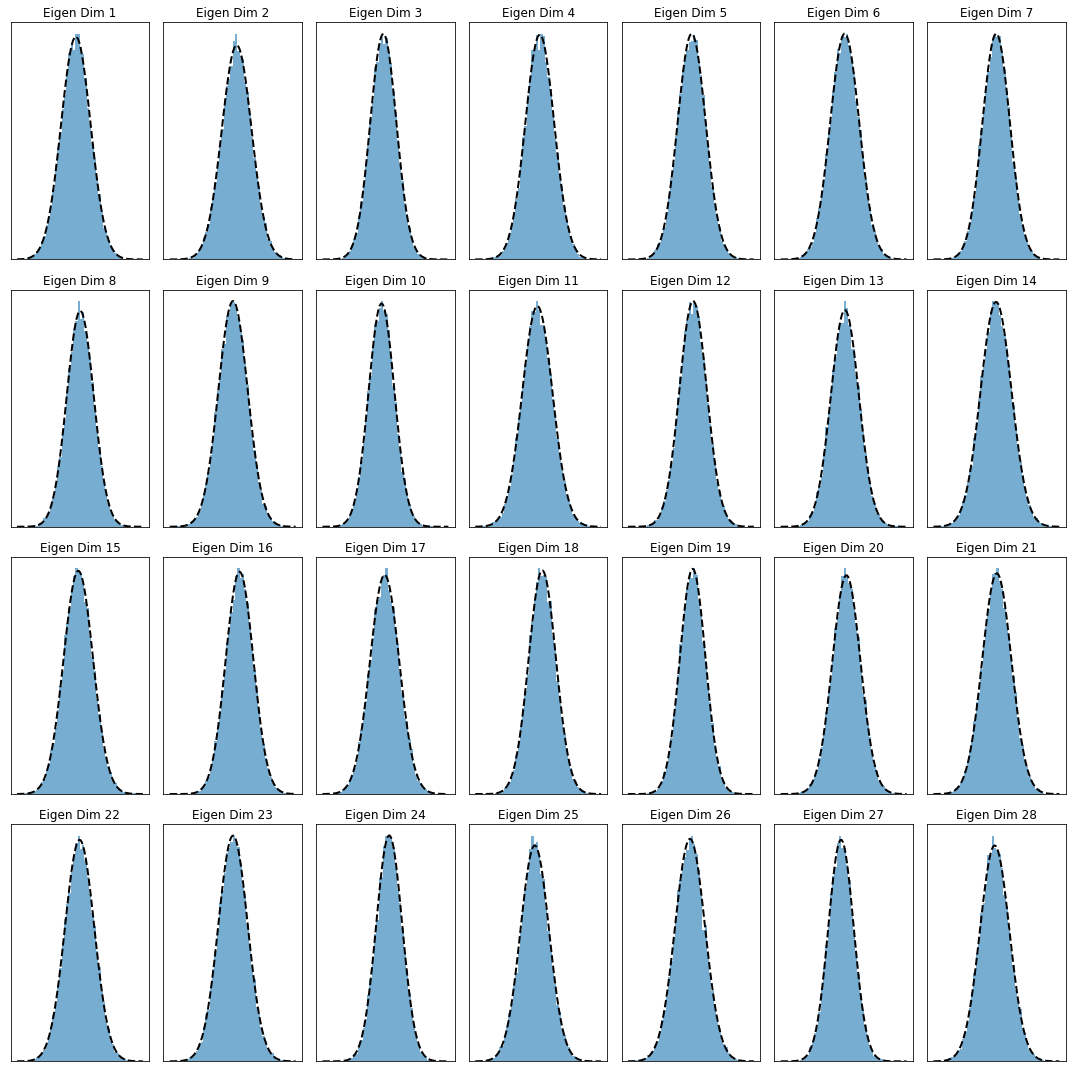

In [1026]:
fig=plt.figure(figsize=(15, 15))
from scipy.stats import norm

columns = 7
rows = 4
for i in range(1, columns*rows +1):
    dim = X_pca[:, i-1]
    fig.add_subplot(rows, columns, i)
    
    # data dist
    plt.hist(dim, bins=50, density=True, alpha=0.6)
    
    # fit gaus
    mu, std = dim.mean(), dim.std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k--', linewidth=2)
    
    plt.title("Eigen Dim %d" % i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

([], [])

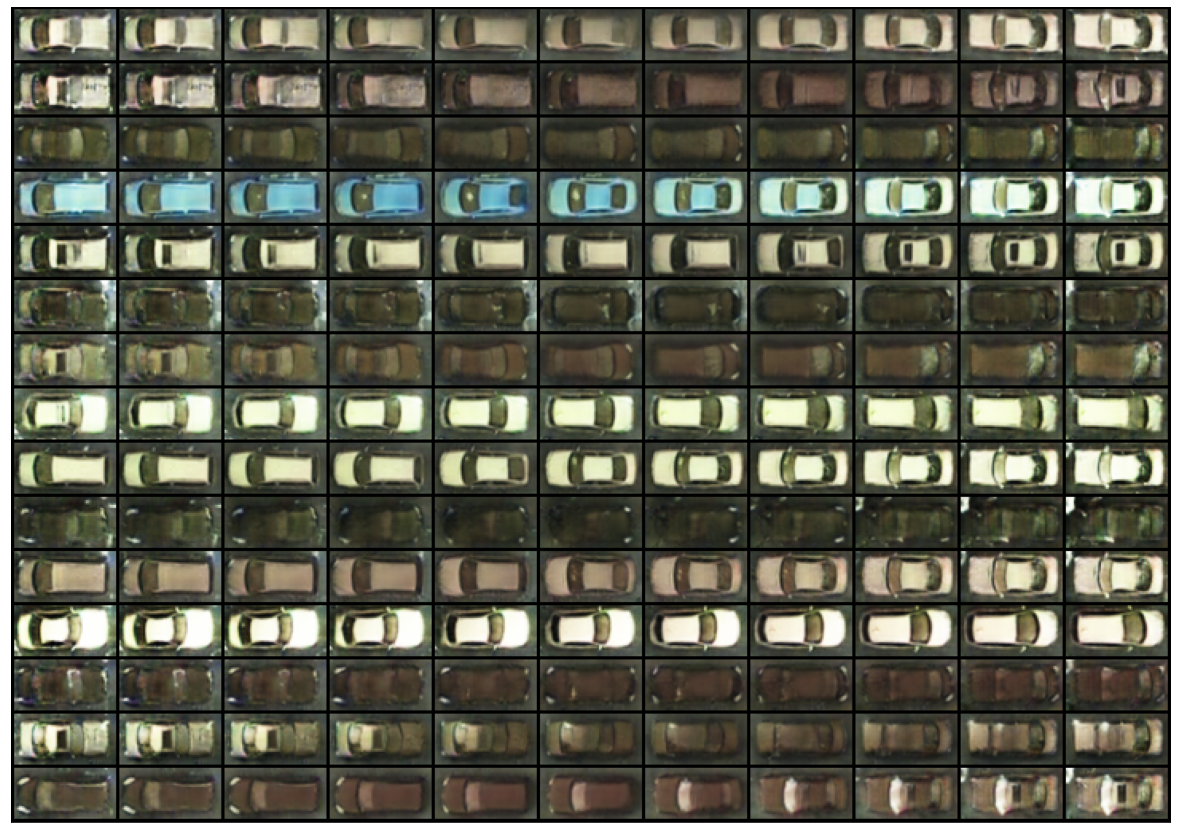

In [ ]:
# input
model_checkpoint = "experiments/dcgan_resnet/lightning_logs/version_0/checkpoints/epoch=524.ckpt"
save_path = "experiments/ganspace/dcgan_resnet_version_0_epoch=524"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 


dims_ = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
ratios_ = [[-50, 50], [-30, 30], 
          [-50, 50], [-50, 50], 
          [-50, 0], [0, 50], 
          [-50, 0], [-50, 50], 
          [0, 40], [-40 , 40], 
          [0, 50], [-50, 50], 
          [-70, 0], [-50, 50]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


In [4]:
# input
model_checkpoint = "experiments/big_image/lightning_logs/version_0/checkpoints/epoch=449.ckpt"
save_path = "experiments/ganspace/big_image_version_0_epoch=449"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 0 : ratio [-50, 50] : make cars white and them left or right
# dim 1 : ratio [-30, 30] : makes cars white van or green
# dim 5 : ratio [-50, 50] : car becomes red or blue
# dim 6 : ratio [-50, 50] : makes car blue or redish with strips on top
# dim 7 : ratio [-50, 0] : adds bright spot in right side
# dim 8 : ratio [0, 50] : adds bright spot in left side
# dim 9 : ratio [-50, 0] : adds bright spot in left side
# dim 10 : ratio [-50, 50] : makes image brighter or darker
# dim 12 : ratio  [0, 40] : tries to add roof
# dim 11 : ratio [-40, 40] : makes bottom part brighter or top part darker
# dim 14 : ratio [0, 50] : makes car longer
# dim 15 : ratio [-50, 50] : adds car light bottom left or bends it to bottom right
# dim 19 : ratio [-70, 0] : bends it to bottom left
# dim 20 : ratio [-50, 50] : makes car smaller or rotates the car


dims_ = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
ratios_ = [[-50, 50], [-30, 30], 
          [-50, 50], [-50, 50], 
          [-50, 0], [0, 50], 
          [-50, 0], [-50, 50], 
          [0, 40], [-40 , 40], 
          [0, 50], [-50, 50], 
          [-70, 0], [-50, 50]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


NameError: name 'model' is not defined

In [5]:
# input
model_checkpoint = "experiments/dataaug/lightning_logs/version_1/checkpoints/epoch=774.ckpt"
save_path = "experiments/ganspace/dataaug_bn_default_epoch=774"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 0 : ratio [-50, 50] : make cars white and them left or right
# dim 1 : ratio [-20, 20] : makes cars white van or green
# dim 3 : ratio [-20, 20] : moves car from top to bottom
# dim 5 : ratio [-40, 40] : car becomes red or gets strips on top
# dim 6 : ratio [-30, 0] : makes car blue
# dim 9 : ratio [-20, 20] : makes image brighter or darker
# dim 10 : ratio [-40, 0] : adds bright spot and makes car green
# dim 11 : ratio [-40, 40] : makes image darker and green or blue and bright spot on bottom
# dim 13 : ratio [-30, 30] : makes image red or green
# dim 14 : ratio [-60, 0] : adds car light front and back
# dim 16 : ratio [-60, 60] : lighting direction
# dim 17 : ratio [-50, 50] : changes the aspect ratio of car + lighting on front or back
# dim 20 : ratio [-40, 40] : twists the car and rotates little bit and adds light spot
# dim 25 : ratio [-70, 70] : makes car green or red and add bright spot on left or right
# dim 44 : ratio [-100, 0] : bending the car

dims_ = [0, 1, 3, 5, 6, 9, 10, 11, 13, 14, 16, 17, 20, 25, 44]
ratios = [[-50, 50], [-20, 20], 
          [-20, 20], [-40, 40], 
          [-30, 0], [-20, 20], 
          [-40, 0], [-40, 40], 
          [-30, 30], [-60 , 0], 
          [-60, 60], [-50, 50], 
          [-40, 40], [-70, 70], 
          [-100, 0]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


NameError: name 'model' is not defined